# NYPD Shooting Incidents Analysis


Violent crime is an ongoing problem in many American cities. Insight into this problem would be of great benefit to law enforcement, policy makers, city planners and residents. The objective of this analysis is to determine what patterns exists in the historical dataset of shooting incidents in New York City, USA.  What are some common themes that can be discovered regarding these shootings? The data will be modeled using methods of time-series analysis.


## Libraries

These libraries were used to work with the data. If the following code fails to execute, the libraries may need to be installed.


In [1]:
library(tidyverse)
library(lubridate)


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




## Overview of the Data

Import the data into the workspace, directly from the source. If there are problems accessing the URL, import the file locally if it exists on the local machine using the commented line of code.


In [2]:
raw <- read_csv("https://data.cityofnewyork.us/api/views/833y-fsy8/rows.csv?accessType=DOWNLOAD")
#raw <- read_csv(file.choose())


Rows: 25596 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): OCCUR_DATE, BORO, LOCATION_DESC, PERP_AGE_GROUP, PERP_SEX, PERP_R...
dbl   (7): INCIDENT_KEY, PRECINCT, JURISDICTION_CODE, X_COORD_CD, Y_COORD_CD...
lgl   (1): STATISTICAL_MURDER_FLAG
time  (1): OCCUR_TIME

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The dataset used in this analysis has been retrieved from the [NYC Open Data](https://opendata.cityofnewyork.us/overview/) website, which is reputable based on the transparency the organization has on their standards of handling and collecting data. Metadata such as descriptions of what data are contained for each column can be found [here](https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Historic-/833y-fsy8).



In [3]:
head(raw)



INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
<dbl>,<chr>,<time>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
24050482,08/27/2006,05:35:00,BRONX,52,0,NA,TRUE,NA,NA,NA,25-44,F,BLACK HISPANIC,1017542,255918.9,40.86906,-73.87963,POINT (-73.87963173099996 40.86905819000003)
77673979,03/11/2011,12:03:00,QUEENS,106,0,NA,FALSE,NA,NA,NA,65+,M,WHITE,1027543,186095.0,40.67737,-73.84392,POINT (-73.84392019199998 40.677366895000034)
226950018,04/14/2021,21:08:00,BRONX,42,0,COMMERCIAL BLDG,TRUE,NA,NA,NA,18-24,M,BLACK,1009489,243050.0,40.83376,-73.90880,POINT (-73.90879517699994 40.83376365400005)
237710987,12/10/2021,19:30:00,BRONX,52,0,NA,FALSE,NA,NA,NA,25-44,M,BLACK,1017440,256046.0,40.86941,-73.88000,POINT (-73.87999831299999 40.86940749200004)
224701998,02/22/2021,00:18:00,MANHATTAN,34,0,NA,FALSE,NA,NA,NA,25-44,M,BLACK HISPANIC,1005426,254690.0,40.86572,-73.92344,POINT (-73.92344088699997 40.86572268100008)
225295736,03/07/2021,06:15:00,BROOKLYN,75,0,NA,TRUE,25-44,M,BLACK HISPANIC,25-44,M,WHITE HISPANIC,1020492,187865.0,40.68226,-73.86933,POINT (-73.86933111399996 40.68225681500007)


Columns representing categorical variables are of type `character`. Nothing interesting is revealed when `summary` is executed on such a dataset with columns encoded this way. These columns are converted to type `factor` to illustrate the various categories contained therein.



In [4]:
raw %>%
  mutate_if(is.character, as.factor) %>%
  summary()


  INCIDENT_KEY            OCCUR_DATE     OCCUR_TIME                  BORO      
 Min.   :  9953245   07/05/2020:   47   Length:25596      BRONX        : 7402  
 1st Qu.: 61593633   09/04/2011:   31   Class1:hms        BROOKLYN     :10365  
 Median : 86437258   07/26/2020:   29   Class2:difftime   MANHATTAN    : 3265  
 Mean   :112382648   08/11/2007:   26   Mode  :numeric    QUEENS       : 3828  
 3rd Qu.:166660833   09/04/2006:   25                     STATEN ISLAND:  736  
 Max.   :238490103   08/15/2020:   24                                          
                     (Other)   :25414                                          
    PRECINCT      JURISDICTION_CODE                   LOCATION_DESC  
 Min.   :  1.00   Min.   :0.0000    MULTI DWELL - PUBLIC HOUS: 4559  
 1st Qu.: 44.00   1st Qu.:0.0000    MULTI DWELL - APT BUILD  : 2664  
 Median : 69.00   Median :0.0000    PVT HOUSE                :  893  
 Mean   : 65.87   Mean   :0.3316    GROCERY/BODEGA           :  622  
 3rd Qu.: 

The dataset contains demographic information about the perpetrator and the victim, such as their sex, race and age. Also included is information about where the crime took place: coordinates, borough, location description, etc. The date and the time the incident occurred is also available, though it would be preferable if the two columns were combined into a DATATIME column. The age columns are categorical, rather than numeric. There appear to be a few outliers in most columns, as evidenced by the *(other)* designation.


## Tidying and Transforming the Data


In [5]:
na <- "UNKNOWN"

shooting_data <- raw %>%
  select(-c(INCIDENT_KEY , X_COORD_CD, Y_COORD_CD, Latitude, Longitude, Lon_Lat)) %>%
  mutate(DATETIME = mdy_hms(paste(OCCUR_DATE, " ", OCCUR_TIME))) %>%
  mutate(year = substring(OCCUR_DATE, 7, 10)) %>%
  mutate(month = substring(OCCUR_DATE, 1, 2)) %>%
  mutate(time = substring(OCCUR_TIME, 1, 2)) %>%
  replace_na(list(LOCATION_DESC = na, PERP_AGE_GROUP = na, PERP_SEX = "U", PERP_RACE = na,
                  VIC_AGE_GROUP = na, VIC_SEX = "U", VIC_RACE = na, JURISDICTION_CODE = -1)) %>%
  mutate_if(is.character, as.factor)


This code chunk ensures that the resulting transformed dataset:

1) Contains columns that contain potentially useful information
2) Date and time data are combined and converted into a useful data type
3) That missing values are handled in a meaningful way
4) That `character` type columns have been converted to a useful format for analysis

### Handling of Missing Values

Inspecting the `summary` of the raw data, it can be observed that several categorical variables have entries for *UNKNOWN*, as well as `na`. It would seem fitting that all `na` entries in these columns be replaced with *UNKNOWN* or *U*, in the case of the `*_SEX` columns. The `na` entries in the  `JURISDICTION_CODE` have been set to `-1`, since data in that column are expected to be integers.

This test should ensure that all `na` entries have been taken care of.


In [6]:
for (col in colnames(shooting_data)) {
  tib <- shooting_data %>% filter(is.na(shooting_data[col]))
  if (dim(tib)[1] > 0) {
    print(tib)
    break
  }
}


## Visualizations and Analysis

Some interesting information about the location of shootings and the demographics of the victims and perpetrators can be seen from the summary of the data:


In [7]:
summary(shooting_data)



      OCCUR_DATE     OCCUR_TIME                  BORO          PRECINCT     
 07/05/2020:   47   Length:25596      BRONX        : 7402   Min.   :  1.00  
 09/04/2011:   31   Class1:hms        BROOKLYN     :10365   1st Qu.: 44.00  
 07/26/2020:   29   Class2:difftime   MANHATTAN    : 3265   Median : 69.00  
 08/11/2007:   26   Mode  :numeric    QUEENS       : 3828   Mean   : 65.87  
 09/04/2006:   25                     STATEN ISLAND:  736   3rd Qu.: 81.00  
 08/15/2020:   24                                           Max.   :123.00  
 (Other)   :25414                                                           
 JURISDICTION_CODE                   LOCATION_DESC   STATISTICAL_MURDER_FLAG
 Min.   :-1.0000   UNKNOWN                  :14977   Mode :logical          
 1st Qu.: 0.0000   MULTI DWELL - PUBLIC HOUS: 4559   FALSE:20668            
 Median : 0.0000   MULTI DWELL - APT BUILD  : 2664   TRUE :4928             
 Mean   : 0.3315   PVT HOUSE                :  893                          

### Temporal Data vs Shooting Frequency

It is not obvious from looking at the `summary` when shootings take place. Bar graphs should assist with illustrating possible time dependence on the frequency of shootings.


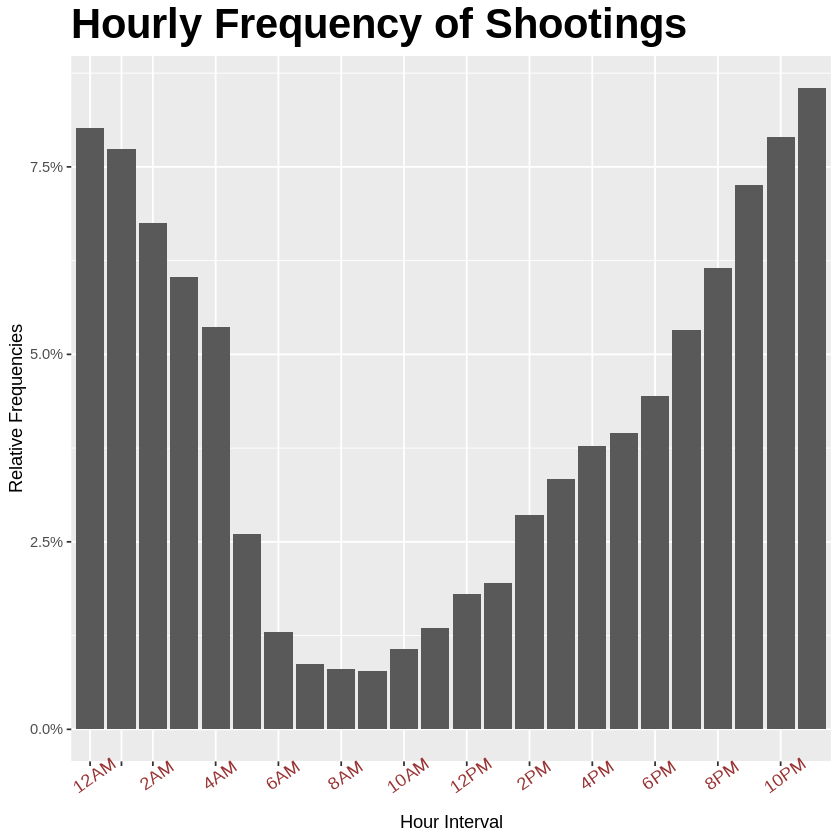

In [8]:
#Label hour intervals so this graph is easier to understand
hrLabel <- function() {
  hrs <- rep("", 24)
  fst <- 12
  lst <- 1
  t1 <- "AM"
  t2 <- "AM"
  for (i in 1:24) {
    if (i %% 2 == 1) {
      hrs[i] = paste(fst, t1, sep = "")
    } else {
      hrs[i] = " "
    }
    fst <- (fst + 1) %% 12
    lst <- (lst + 1) %% 12
    if (fst == 0) {
      fst <- 12
      t1 <- "PM"
    }
    if (lst == 0) {
      lst <- 12
      t2 <- "PM"
    }
  }
  hrs
}

shooting_data %>%                                                                                             
  mutate(Hour = hour(DATETIME)) %>%
  ggplot(aes(Hour+1)) +                                                                                   
  geom_bar(aes(y = (..count..)/sum(..count..))) +  
  scale_y_continuous(labels=scales::percent) + 
  ggtitle("Hourly Frequency of Shootings") +  
  xlab("Hour Interval") +
  ylab("Relative Frequencies") +
  scale_x_discrete(limits=hrLabel()) +
  theme(plot.title = element_text(size = 25, face = "bold")) + 
  theme(axis.text.x = element_text(color = "#993333", 
                                     size = 11, angle = 35))


Are there certain times of the day when shootings are more frequent? This illustration seems to indicate that is the case. The frequency of shootings varies, on average, during the course of the day, with a peak around 8% of the day's incidents from 11PM-12AM, falling into the morning to a minimum of less than 1% from 9AM - 10AM and rising until 11PM.



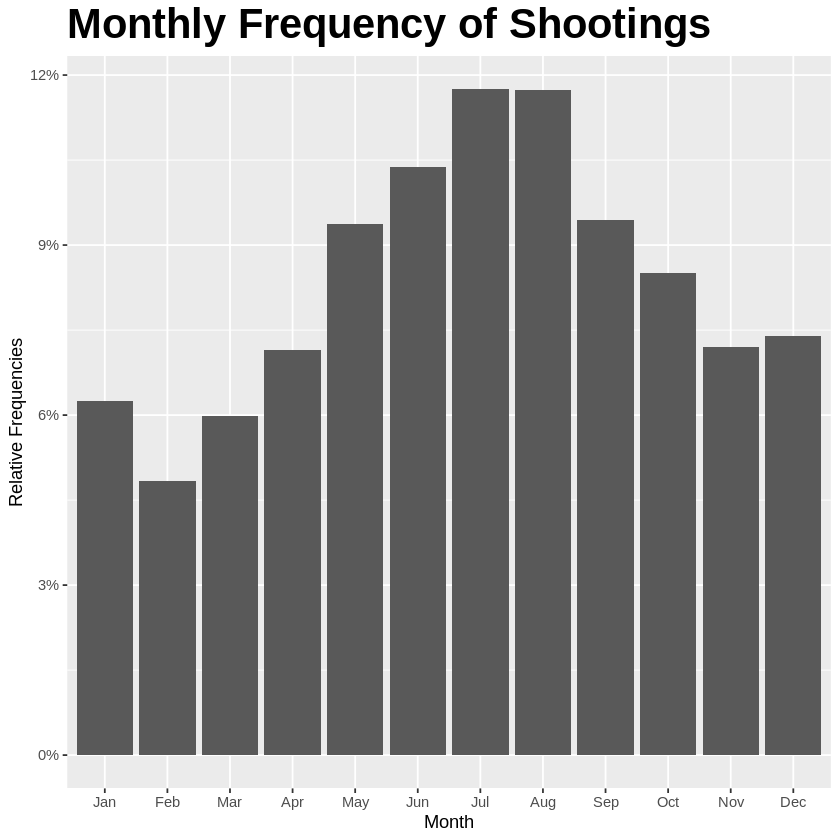

In [9]:
shooting_data %>%                                                                                             
  mutate(Month = month(DATETIME)) %>%                                                                                
  ggplot(aes(Month)) +                                                                                              
  geom_bar(aes(y = (..count..)/sum(..count..))) +  
  scale_y_continuous(labels=scales::percent) + 
  ggtitle("Monthly Frequency of Shootings") +   
  ylab("Relative Frequencies") + 
  scale_x_discrete(limits = month.abb) +
  theme(plot.title = element_text(size = 25, face = "bold"))   


It also appears that the frequency of shootings varies by month. There appears to be a steady increase of incidents starting in the middle of winter and peaking in the middle of summer, only to decline into the winter. This leads to the question: Does the summer season have, on average, a disproportionate number of incidents?



In [10]:
summerCount <- shooting_data %>%                                                                                             
  filter(month(DATETIME) >= 6 & month(DATETIME) <= 8) %>%
  nrow()


## Modeling

Let us create a time-series model that can explain some of the variation in the number of shootings observed in the city. 


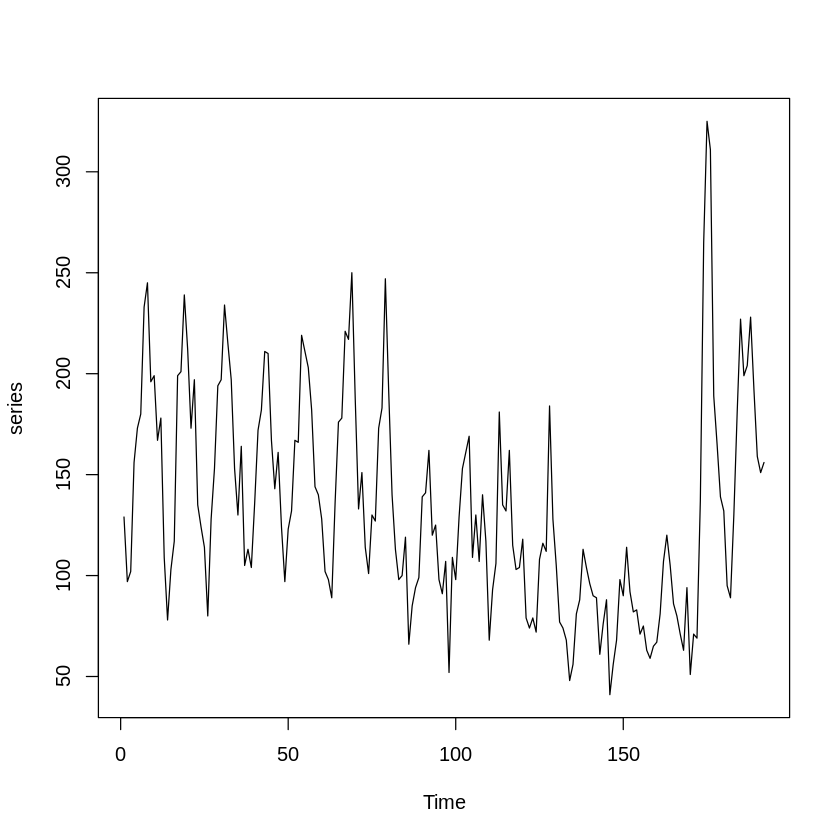

In [11]:
grouped = shooting_data %>%
  group_by(year, month) %>%
  count()

series = ts(grouped$n)
plot(series)


The plot above shows the monthly number of shootings in New York over the past several years. It is apparent that there is strong seasonality in this series - similar times of the year have a similar frequency of shootings. This is backed up too by the previous exploratory data analysis. In addition, this conclusion is further backed up by the ACF (auto-correlation function) plot below, which shows that the present number of shootings is associated with the number of shootings a year ago from some arbitrary month. There also seems to be a slight downward trend in the data, which is abruptly ended by at spike and fall in shootings.



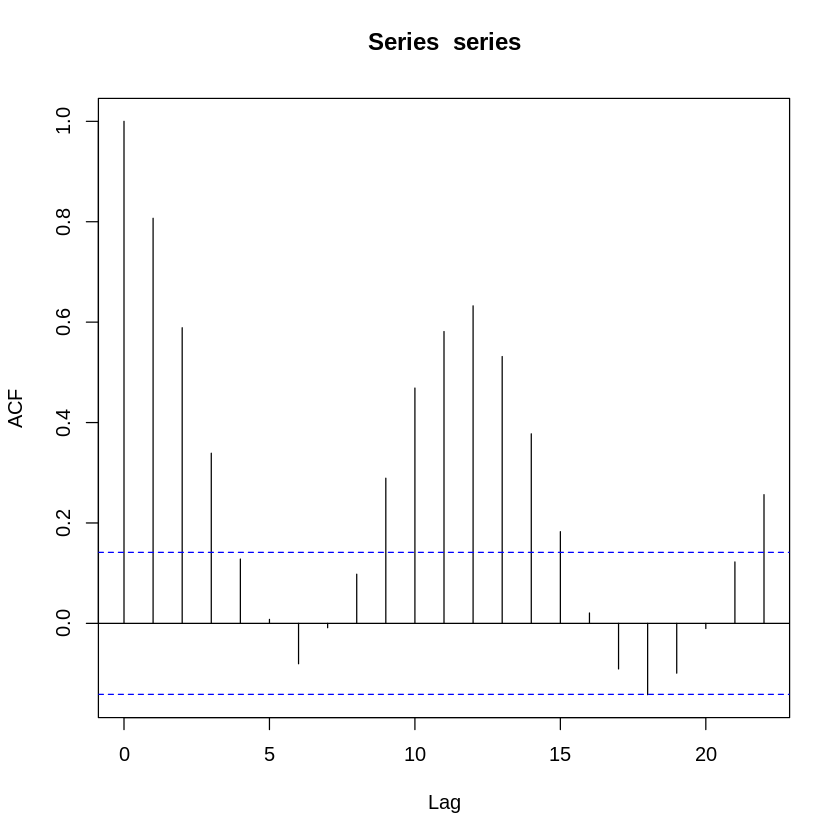

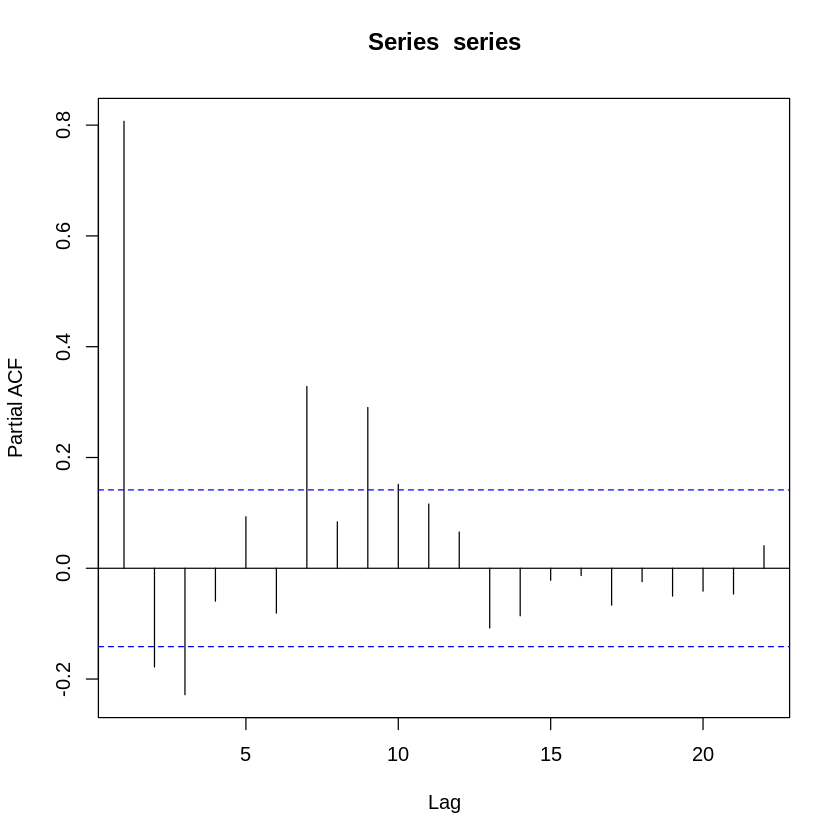

In [12]:
acf(series)
pacf(series)


In addition, both the ACF and the PACF (Partial Auto-Correlation Function) plots indicate that the frequency of shootings that take place in some month is associated with the number of shootings that took place 1 or 2 months prior. It is possible that there is a auto-regressive process or a moving-average process generating these data. There are spikes in the PACF plot at 6 and 9 months respectively. This could be possible indication of higher frequency seasonality. Also possible is that this is an artifact from the outlier spike in shootings.

The true process that generates these data may have up to two auto-regressive or moving-average terms. It is also possible that there is some trend in the data, so an integrated term may exist also. It is obvious that there is seasonality in the data, with period 12. What may not be so obvious is the nature of the seasonality (i.e. integrated, auto-regressive, moving-average). Given these constraints, various models can be fitted and compared using the Akaike Information Criterion, which is a metric that estimates how close a proposed model is to the true model that produces these data. The model below is the best one (i.e. lowest AIC), given the constraints.


In [13]:
model = arima(series, order = c(1, 1, 1), seasonal = list(order = c(0,1, 1), period = 12))
model$aic

model$sigma2
var(series)


[1] 1689.511

[1] 581.9227

[1] 2831.253

It looks like the model does explain some variation in the number of shootings. The residual variance is about 4 times less than the null variance. Let us examine some diagnostic plots of the residuals to see if the model has accounted for all the possible variance.



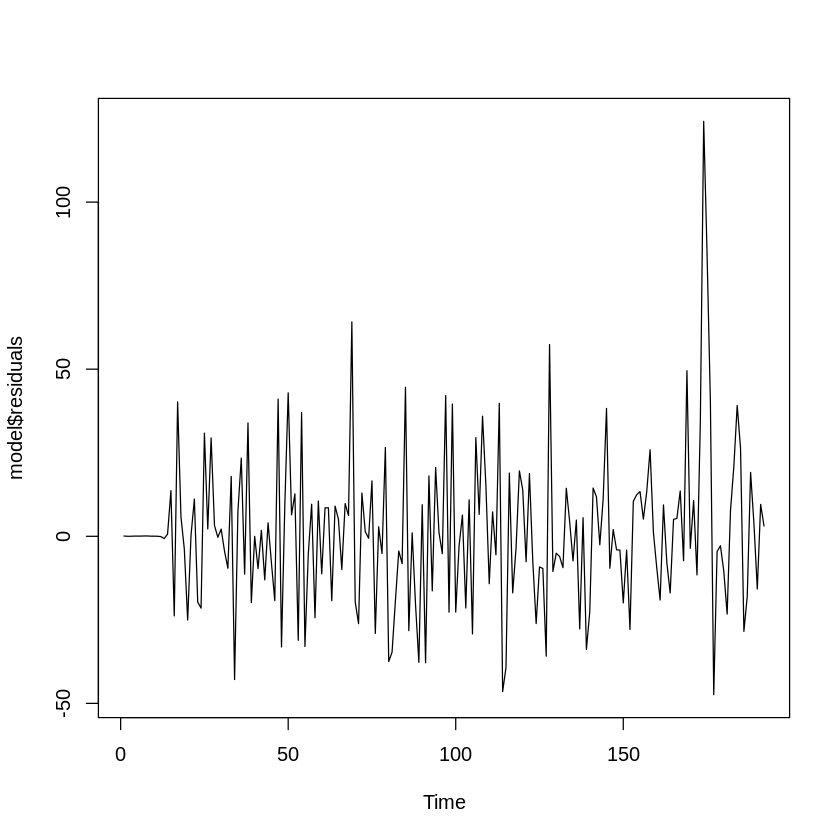

In [17]:
plot(model$residuals)

The residuals appear to be stationary, aside from a few outliers. I do not see any trends or indication of dependencies on prior months' shootings or prior months' anomalies.

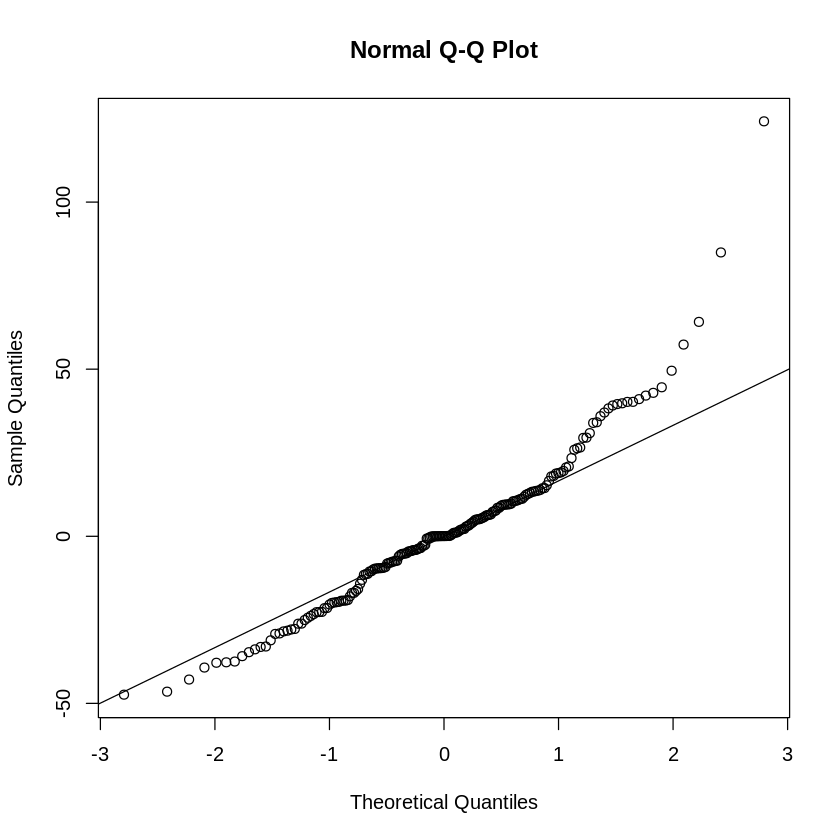

In [18]:
qqnorm(model$residuals)
qqline(model$residuals)

 The distribution of the residuals does appear to deviate from normality. Even though count data is generated from a Poisson process, the data should still be approximately normal by the Central Limit Theorem. This plot shows some evidence that there is some variance left unaccounted for in the model.

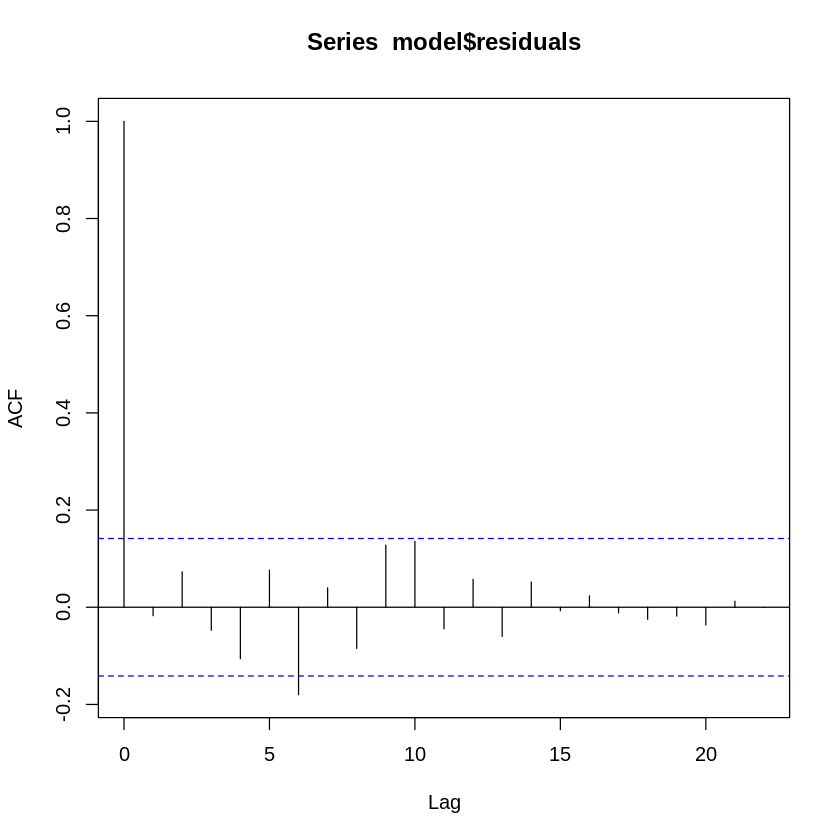

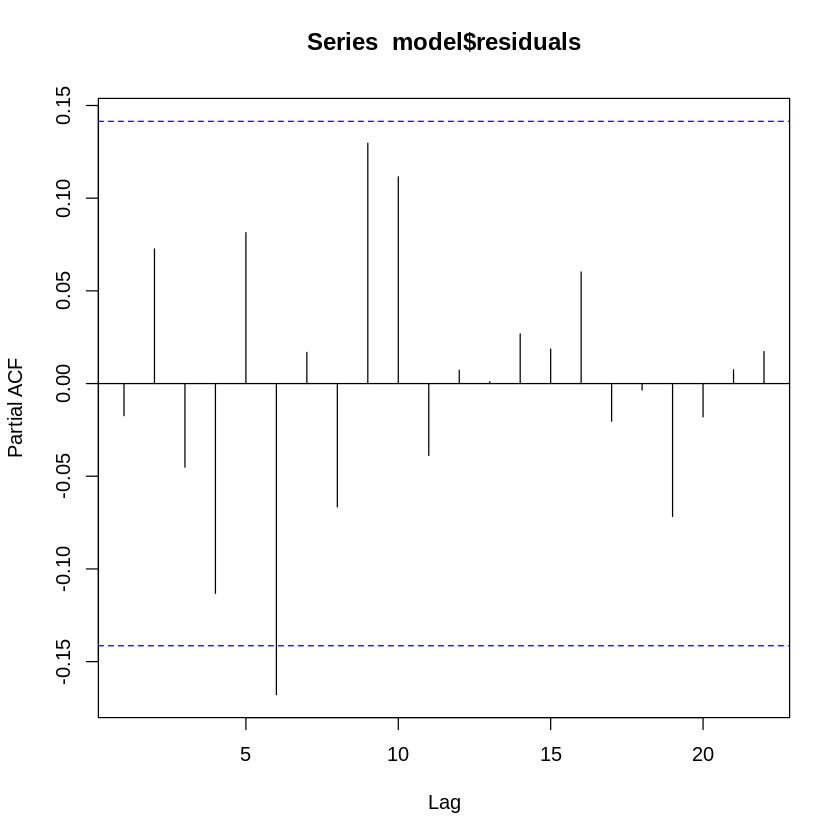

In [19]:
acf(model$residuals)
pacf(model$residuals)

The ACF and PCF don't provide much evidence for latent auto-regressive or moving-average components. However, there is a slight spike at 6-months shown in both plots that may be significant. Perhaps this is evidence that there may be 6-month seasonality in the data.

The plot below is a forecast number of shooting for the next 150 days, from the time of the most recent record in the dataset.


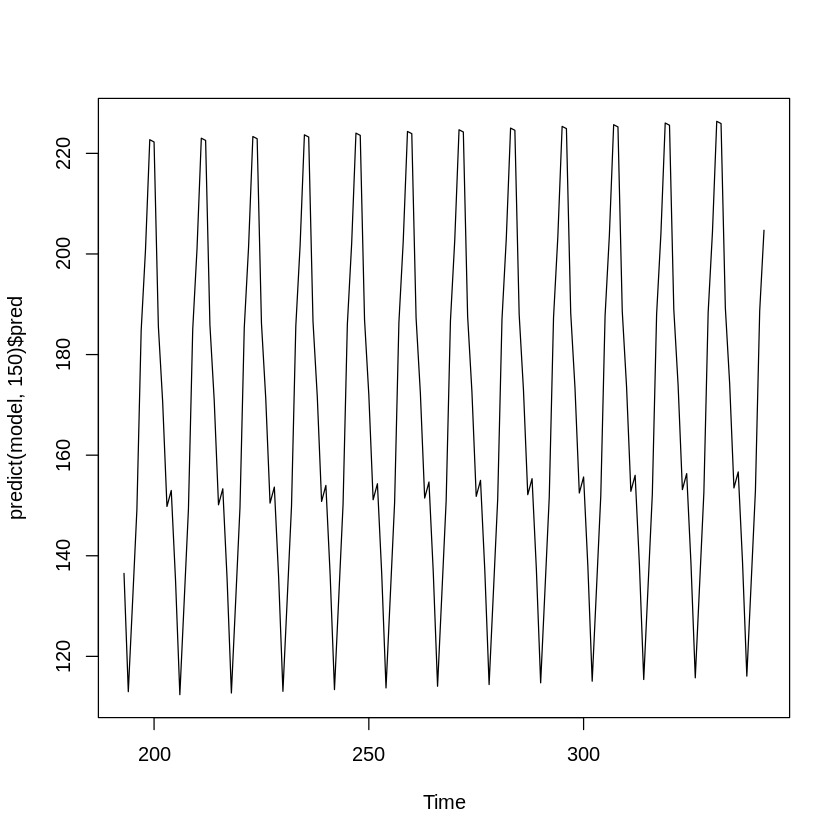

In [15]:
plot(predict(model, 150)$pred)




### Session Info


In [16]:
sessionInfo()



R version 4.2.0 (2022-04-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lubridate_1.8.0 forcats_0.5.1   stringr_1.4.0   dplyr_1.0.9    
 [5] purrr_0.3.4     readr_2.1.2     tidyr_1.2.0     tibble_3.1.7   
 [9] ggplot2_3.3.6   tidyverse_1.3.1

loaded via a namespace (and not attached):
 [1] assertthat_0.2.1 digest_0.6.29    utf8_1.2.2  